In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
customers = pd.read_csv("Ecommerce/olist_customers_dataset.csv")
order_items = pd.read_csv("Ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("Ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("Ecommerce/olist_products_dataset.csv")
reviews = pd.read_csv("Ecommerce/olist_order_reviews_dataset.csv")
category_map = pd.read_csv("Ecommerce/product_category_name_translation.csv")


products = products.merge(category_map, on="product_category_name", how="left")
products = products.drop(columns=['product_category_name'])
products = products.rename(columns={'product_category_name_english': 'product_category'})

display(order_items.head())
display(products.head())
display(orders.head())

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [3]:
# product_id 기준으로 orders_item이랑 products 병합
# order_id 기준으로 orders랑 병합

# 1️⃣ products와 order_items 병합 (product_id 기준)
items_with_category = order_items.merge(products[['product_id','product_category']], on='product_id', how='left')

# 2️⃣ orders와 병합 (order_id 기준)
full_order_data = items_with_category.merge(
    orders[['order_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']],
    on='order_id',
    how='left'
)

# 3️⃣ 주문일자 datetime 변환
full_order_data['order_purchase_timestamp'] = pd.to_datetime(full_order_data['order_purchase_timestamp'])
full_order_data['order_delivered_customer_date'] = pd.to_datetime(full_order_data['order_delivered_customer_date'])
full_order_data['order_estimated_delivery_date'] = pd.to_datetime(full_order_data['order_estimated_delivery_date'])

# 배송 성공한 애들만 볼 거임!
success_full_orders = full_order_data[full_order_data['order_delivered_customer_date'].notna()].copy()

# 확인
success_full_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17


In [4]:
# 카테고리별 항목 확인
category_summary = success_full_orders.groupby('product_category')['order_id'].count().reset_index()
category_summary.rename(columns={'order_id':'주문건수'}, inplace=True)
category_summary = category_summary.sort_values(by='주문건수', ascending=False)

category_summary.head(10)  # 상위 10개 카테고리 확인

,product_category,주문건수
7,bed_bath_table,10953
43,health_beauty,9467
65,sports_leisure,8431
39,furniture_decor,8160
15,computers_accessories,7643
49,housewares,6795
70,watches_gifts,5857
68,telephony,4430
42,garden_tools,4268
5,auto,4139


,order_month,product_category,월별주문건수
0,2016-09,health_beauty,3
1,2016-10,air_conditioning,8
2,2016-10,audio,2
3,2016-10,auto,8
4,2016-10,baby,11


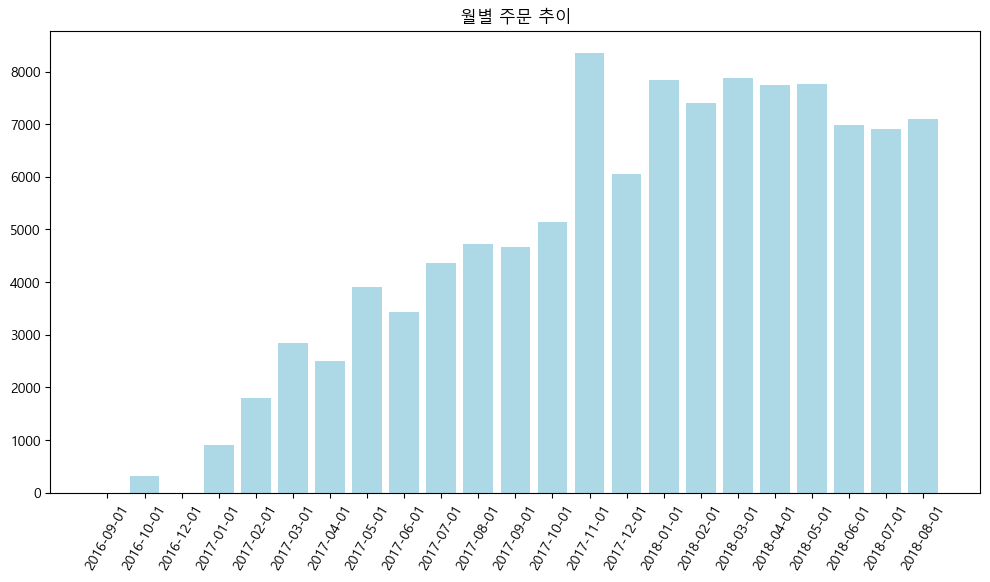

,order_month,product_category,월별주문건수
0,2016-09-01,health_beauty,3
1,2016-10-01,furniture_decor,65
2,2016-10-01,health_beauty,41
3,2016-10-01,perfumery,31
4,2016-12-01,fashion_bags_accessories,1


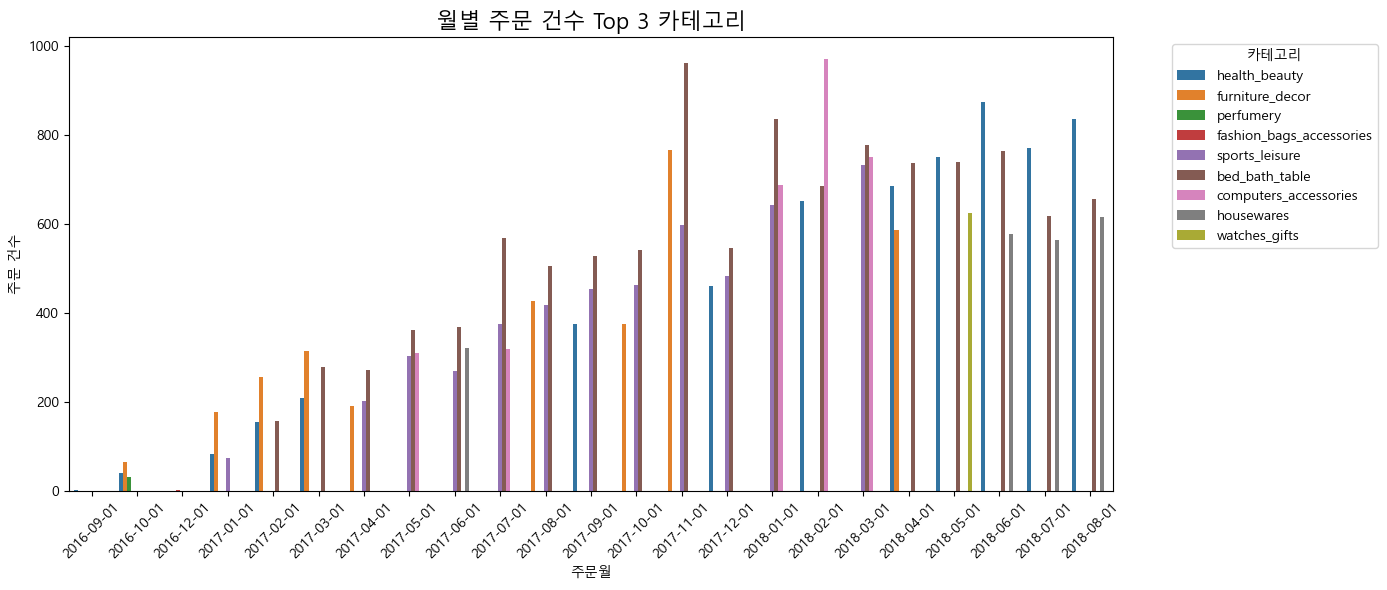

In [60]:
# 주문월 컬럼 추가
success_full_orders['order_month'] = success_full_orders['order_purchase_timestamp'].dt.to_period('M')

# 월별, 카테고리별 주문 건수
monthly_category_trend = success_full_orders.groupby(['order_month','product_category'])['order_id'].count().reset_index()
monthly_category_trend.rename(columns={'order_id':'월별주문건수'}, inplace=True)
monthly_category_trend.groupby('order_month')
display(monthly_category_trend.head())

# order_month를 datetime으로 변환!!!!!!!!!!!!!!!
monthly_category_trend['order_month'] = monthly_category_trend['order_month'].dt.to_timestamp()


# 월별 주문 추이 막대그래프
monthly_total = monthly_category_trend.groupby('order_month')['월별주문건수'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.bar(monthly_total['order_month'].astype(str), monthly_total['월별주문건수'], color='lightblue')
plt.xticks(rotation=60)
plt.title('월별 주문 추이')
plt.show()




# 월별 주문건수 topN개 뽑기
N = 3
monthly_topN = (monthly_category_trend
    .sort_values(['order_month', '월별주문건수'], ascending=[True, False])
    .groupby('order_month')
    .head(N)
    .reset_index(drop=True)
)
display(monthly_topN.head())


# 월별 top3 시각화
plt.figure(figsize=(14,6))
sns.barplot(
    data=monthly_topN,
    x='order_month',
    y='월별주문건수',
    hue='product_category'
)

plt.title('월별 주문 건수 Top 3 카테고리', fontsize=16)
plt.xlabel('주문월')
plt.ylabel('주문 건수')
plt.legend(title='카테고리', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 계절성 패턴 파악

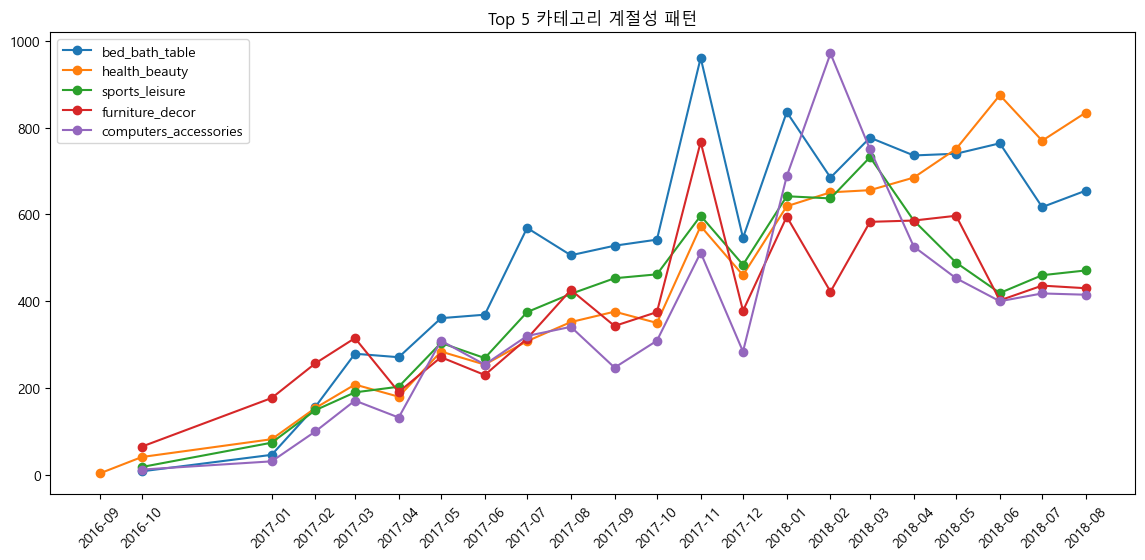

In [ ]:
top_categories = monthly_category_trend.groupby('product_category')['월별주문건수'].sum().nlargest(5).index
seasonal_trend = monthly_category_trend[monthly_category_trend['product_category'].isin(top_categories)]
# display(seasonal_trend)

# display(seasonal_trend[seasonal_trend['order_month'].dt.month == 11])
# display(seasonal_trend[seasonal_trend['product_category'] == 'health_beauty'])
# display(seasonal_trend[seasonal_trend['product_category'] == 'bed_bath_table'])

plt.figure(figsize=(14,6))
for cat in top_categories:
    subset = seasonal_trend[seasonal_trend['product_category'] == cat]
    plt.plot(subset['order_month'], subset['월별주문건수'], marker='o', label=cat)

plt.xticks(
    ticks=seasonal_trend['order_month'].unique(),
    labels=[x.strftime('%Y-%m') for x in seasonal_trend['order_month'].unique()],
    rotation=45
)
plt.title('Top 5 카테고리 계절성 패턴')
plt.legend()
plt.show()

In [ ]:
# 주요 인사이트
# 1. 11월 모든 카테고리에서 매출 급증.
# 2. 11월에 'bed_bath_table', 'furniture_decor' 카테고리가 급증 -> 브라질의 주요 쇼핑 시즌
# 3. 2월에 'computer' 액세서리 카테고리가 급증 이유 -> 학사 일정과 관련

# 11월 'bed_bath_table' 급증: 블랙 프라이데이 (Black Friday)
# 11월에 침구, 욕실용품, 테이블웨어와 같은 가정용품 판매가 급증한 것은 블랙 프라이데이 때문일 가능성이 매우 높습니다.
# 대규모 할인 행사: 브라ジル에서 블랙 프라이데이는 연중 가장 큰 쇼핑 이벤트 중 하나입니다. 단 하루가 아닌 '블랙 위크(Black Week)' 또는 '블랙 노벰버(Black November)'로 
# 불리며 한 달 내내 대규모 할인 행사가 진행됩니다.
# 가정용품 인기: 이 기간 동안 소비자들은 평소에 가격이 부담스러웠던 가구, 전자제품, 그리고 침구 및 생활용품(bed_bath_table)을 저렴하게 구매하려는 경향이 강합니다. 
# 연말을 맞이하여 집안을 새롭게 단장하려는 수요와 맞물려 해당 카테고리의 매출이 폭발적으로 증가하게 됩니다.

# 2월 'computer' 액세서리 급증: 신학기 준비 (Volta às Aulas)
# 2월에 컴퓨터 액세서리 판매가 급증한 이유는 브라질의 신학기 시작과 관련이 있습니다.
# 'Volta às Aulas' (Back to School): 브라질의 학년은 보통 2월에 시작됩니다. 따라서 1월 말부터 2월까지는 학생들이 학교로 돌아가는 것을 준비

# 학습 준비물 수요: 이 기간 동안 학생과 학부모들은 새 학년에 필요한 학습 준비물을 구매합니다. 최근 교육 환경이 디지털화되면서 노트북, 태블릿과 같은 기기뿐만 아니라 
# 키보드, 마우스, 웹캠, 헤드셋 등 컴퓨터 관련 액세서리 수요가 크게 증가합니다. 많은 유통업체들이 이 시기에 맞춰 전자제품 및 컴퓨터 액세서리 할인 프로모션을 
# 진행하는 것도 매출 급증의 한 요인입니다.

# 건강관련 용품은 꾸준히 증가하는데
# 6월 판매 급증의 핵심 원인
# 1. 연인들의 날 (Dia dos Namorados)
# 가장 큰 이유는 브라질의 '밸런타인데이'인 '연인들의 날'(6월 12일) 때문입니다. 전 세계 많은 나라가 2월 14일을 기념하는 것과 달리, 
# 브라질은 6월 12일에 연인들이 선물을 주고받으며 사랑을 표현합니다.
# 주요 선물 품목: 향수, 화장품 세트, 스킨케어 제품, 남성용 그루밍 제품 등 헬스뷰티 카테고리는 '연인들의 날'에 가장 인기 있는 선물 중 하나입니다.
# 수요 집중: 6월 초부터 기념일을 준비하기 위한 선물 구매 수요가 몰리면서 헬스뷰티 카테고리의 매출이 단기적으로 급증하게 됩니다.

# 7월 판매량 소폭 감소 이유
# 6월에 급증했던 판매량이 7월에 다소 감소하는 것은 자연스러운 조정 현상으로 볼 수 있습니다.
# 기념일 특수 종료: '연인들의 날'이라는 이벤트가 끝나면서 선물 목적의 집중 소비가 사라져 판매량이 평소 수준으로 돌아가게 됩니다.
# 겨울 휴가 시즌: 7월은 브라질의 겨울 방학 및 휴가 시즌이기도 합니다. 이 시기에는 소비 지출이 여행이나 여가 활동으로 분산될 수 있습니다.

In [ ]:
# 카테고리별 통계 계산
stats = monthly_category_trend.groupby('product_category')['월별주문건수'].agg(['mean','std']).reset_index()

# 원본 데이터에 통계 합치기
df = monthly_category_trend.merge(stats, on='product_category')

# 위험 구간 표시
df['재고부족위험'] = df['월별주문건수'] > (df['mean'] + df['std'])
df['과잉재고위험'] = df['월별주문건수'] < (df['mean'] - df['std'])

# 월별, 카테고리별 재고부족or과잉재고 확인
df[['order_month','product_category','월별주문건수','재고부족위험','과잉재고위험']]
display(df.head())

# 카테고리별로 재고부족, 과잉재고 월수 얼마나 되는지 체크
category_risk = df.groupby('product_category').agg(
    재고부족_월수=('재고부족위험','sum'),
    과잉재고_월수=('과잉재고위험','sum')
).reset_index()

category_risk

,order_month,product_category,월별주문건수,ds,y,mean,std,재고부족위험,과잉재고위험
0,2016-09-01,health_beauty,3,2016-09-01,3,430.318182,269.743332,False,True
1,2016-10-01,air_conditioning,8,2016-10-01,8,13.761905,6.934730,False,False
2,2016-10-01,audio,2,2016-10-01,2,18.100000,10.140591,False,True
3,2016-10-01,auto,8,2016-10-01,8,197.095238,117.951221,False,True
4,2016-10-01,baby,11,2016-10-01,11,142.000000,75.963807,False,True


,product_category,재고부족_월수,과잉재고_월수
0,agro_industry_and_commerce,3,2
1,air_conditioning,4,3
2,art,3,0
3,arts_and_craftmanship,2,0
4,audio,4,4
...,...,...,...
66,stationery,2,2
67,tablets_printing_image,2,4
68,telephony,4,3
69,toys,2,3


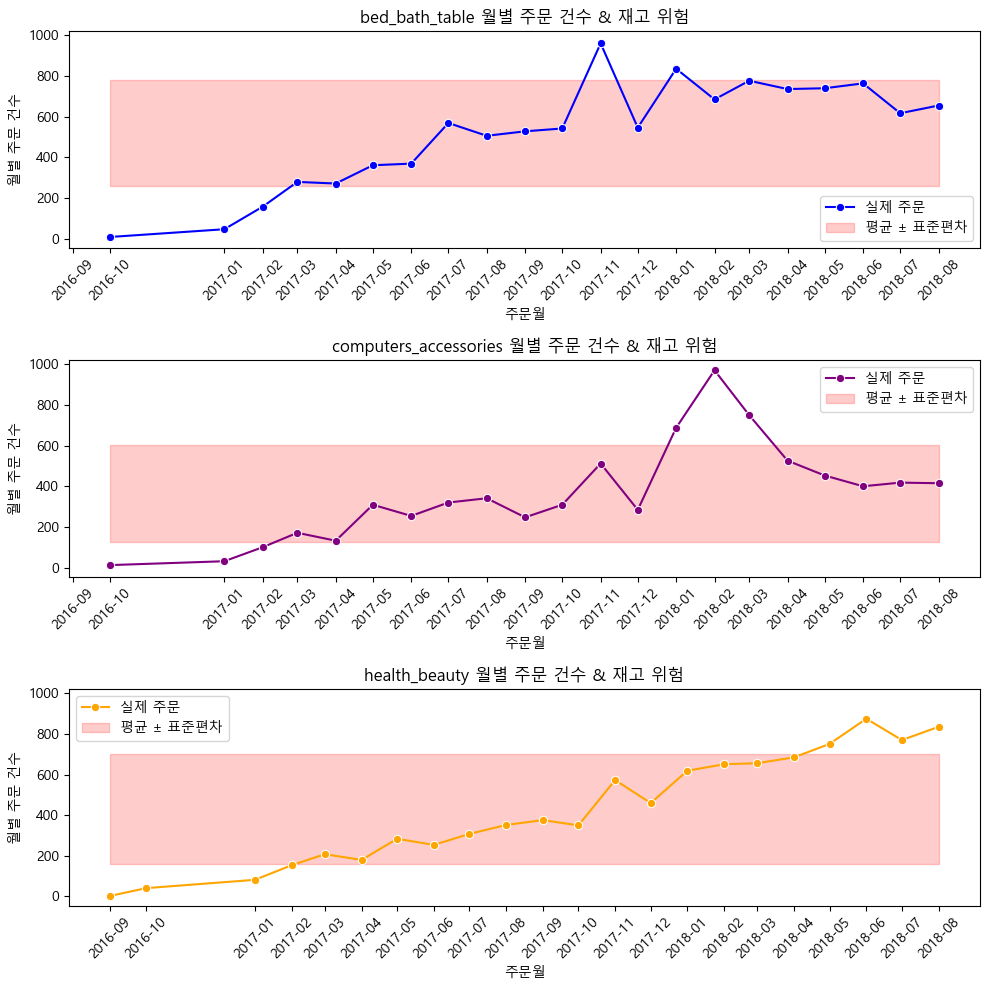

In [58]:
# 보고 싶은 카테고리 리스트
categories = ['bed_bath_table', 'computers_accessories', 'health_beauty']

# subplot 설정
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharey=True)
axes = axes.flatten()

for i, cat in enumerate(categories):
    df_cat = df[df['product_category']==cat].sort_values('order_month')
    line_colors = {
    'bed_bath_table': 'blue',
    'computers_accessories': 'purple',   # 보라색
    'health_beauty': 'orange'           # 주황색
}

    # 실제 주문 건수
    sns.lineplot(data=df_cat, x='order_month', y='월별주문건수', marker='o', ax=axes[i], label='실제 주문',color=line_colors[cat])
    
    # 평균 ± 표준편차 구간
    axes[i].fill_between(df_cat['order_month'],
                         df_cat['mean']+df_cat['std'],
                         df_cat['mean']-df_cat['std'],
                         color='red', alpha=0.2, label='평균 ± 표준편차')
    
    axes[i].set_title(f'{cat} 월별 주문 건수 & 재고 위험')
    axes[i].set_xlabel('주문월')
    axes[i].set_ylabel('월별 주문 건수')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()
    
    for ax in axes:
        ax.set_xticks(df_cat['order_month'])  # 모든 월 표시
        ax.set_xticklabels(df_cat['order_month'].dt.strftime('%Y-%m'), rotation=45)

plt.tight_layout()

plt.show()

In [62]:
print('''
 1️⃣ bed_bath_table

11월 급증: 파란선이 크게 튀어 있음 → 재고 부족 위험 매우 높음
전략: 11월 전에 재고 충분히 확보, 나머지 달은 재고 조절

      
2️⃣ computers_accessories

12월~2월 급증: 보라색 선이 빨간 음영 위로 → 재고 부족 위험
특징: 시즌성 강함 (학기 시작/연말 행사 영향)
전략: 학기 시작 전, 연말 행사 전 집중 재고 확보


3️⃣ health_beauty

전체적으로 상승 추세: 주황색 선이 대부분 빨간 음영 상단 근처 → 재고 부족 위험 지속
특징: 과잉 재고 거의 없음 → 꾸준히 인기 카테고리
전략: 안정적인 공급 관리, 재고 부족 대비 지속 필요

      
🔹 종합 인사이트
bed_bath_table → 11월 블랙프라이데이 시즌 전 재고 확보, 나머지 달은 과잉 재고 주의
computers_accessories → 시즌성 강한 카테고리, 학기/연말 이벤트 전 집중 재고 확보
health_beauty → 전반적으로 인기 높음, 꾸준한 재고 유지 필요 '''  )


 1️⃣ bed_bath_table

11월 급증: 파란선이 크게 튀어 있음 → 재고 부족 위험 매우 높음
전략: 11월 전에 재고 충분히 확보, 나머지 달은 재고 조절


2️⃣ computers_accessories

12월~2월 급증: 보라색 선이 빨간 음영 위로 → 재고 부족 위험
특징: 시즌성 강함 (학기 시작/연말 행사 영향)
전략: 학기 시작 전, 연말 행사 전 집중 재고 확보


3️⃣ health_beauty

전체적으로 상승 추세: 주황색 선이 대부분 빨간 음영 상단 근처 → 재고 부족 위험 지속
특징: 과잉 재고 거의 없음 → 꾸준히 인기 카테고리
전략: 안정적인 공급 관리, 재고 부족 대비 지속 필요


🔹 종합 인사이트
bed_bath_table → 11월 블랙프라이데이 시즌 전 재고 확보, 나머지 달은 과잉 재고 주의
computers_accessories → 시즌성 강한 카테고리, 학기/연말 이벤트 전 집중 재고 확보
health_beauty → 전반적으로 인기 높음, 꾸준한 재고 유지 필요 


In [9]:
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
%pip install --upgrade pip setuptools wheel

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install -q prophet

Note: you may need to restart the kernel to use updated packages.


11:18:38 - cmdstanpy - INFO - Chain [1] start processing
11:18:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\agnes\pjt-ecommerce-data-analysis\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


           ds          yhat    yhat_lower    yhat_upper
21 2018-08-31  9.223477e+06  9.109581e+06  9.338157e+06
22 2018-09-30  1.679871e+10  1.614242e+10  1.747151e+10
23 2018-10-31  7.813979e+00  7.196093e+00  8.534876e+00
24 2018-11-30 -9.999999e-01 -9.999999e-01 -9.999999e-01
25 2018-12-31  1.025205e+09  8.728205e+08  1.227726e+09
26 2019-01-31  2.868775e+05  2.311437e+05  3.659978e+05
27 2019-02-28  3.176365e+04  2.385786e+04  4.259834e+04
28 2019-03-31  1.178367e+04  8.351234e+03  1.706693e+04
29 2019-04-30  1.494712e+03  9.783721e+02  2.335089e+03
30 2019-05-31  1.043424e+03  6.353099e+02  1.764828e+03
31 2019-06-30  2.881831e+01  1.593415e+01  5.339346e+01
32 2019-07-31  9.262752e+01  4.800073e+01  1.876467e+02


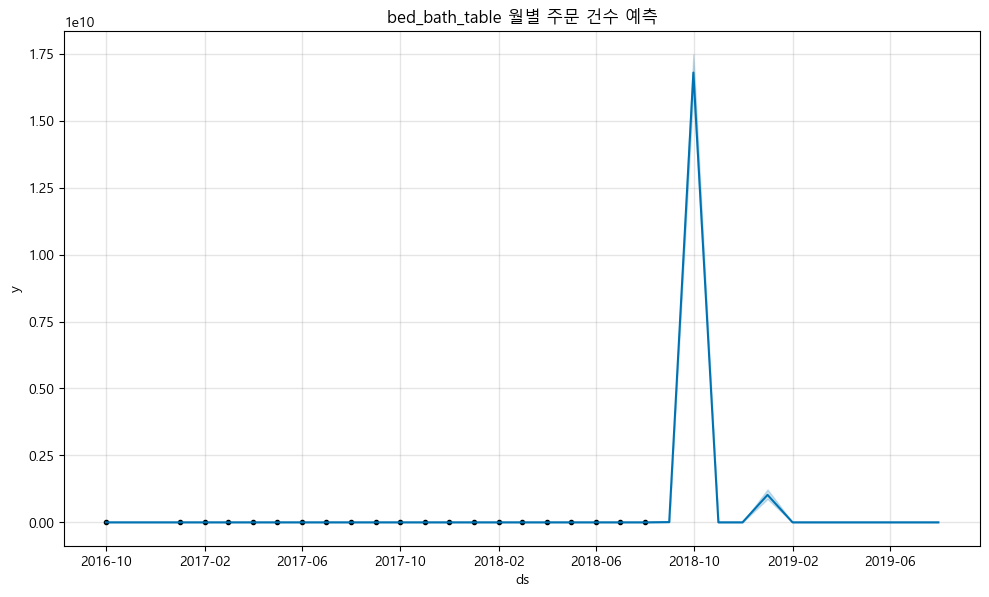

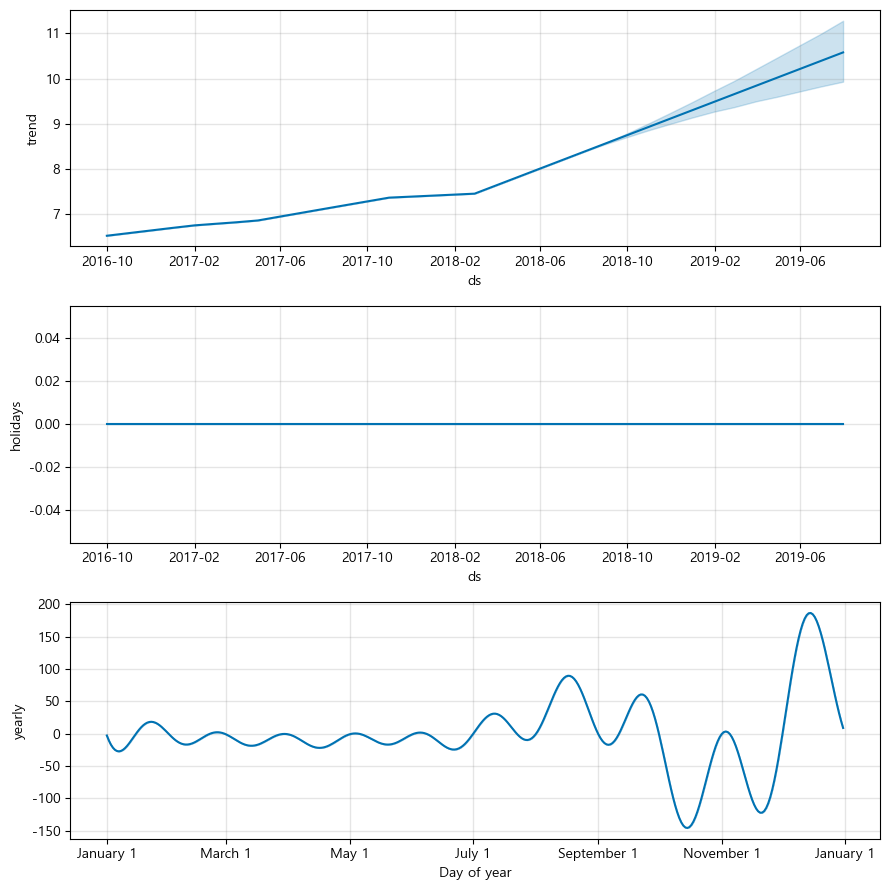

In [30]:
from prophet import Prophet

# ds 컬럼으로 변환 (Prophet 요구)
monthly_category_trend['ds'] = pd.to_datetime(monthly_category_trend['order_month']).dt.to_period('M').dt.to_timestamp()
monthly_category_trend['y'] = monthly_category_trend['월별주문건수']

# 특정 카테고리 선택 (예: bed_bath_table)
df_cat = monthly_category_trend[monthly_category_trend['product_category']=='bed_bath_table'][['ds','y']]

# 로그 변환 (변동폭이 큰 경우 안정화)
df_cat['y'] = np.log1p(df_cat['y'])

events = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(['2016-11-25', '2018-11-24']),  # 2년치 데이터 기준
    'lower_window': 0,
    'upper_window': 1
})


model = Prophet(yearly_seasonality=True, holidays=events)
model.fit(df_cat)

# 미래 12개월 예측
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# 예측값 원래 스케일로 변환
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])


# 최근 예측값 확인
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12))

# 그래프 시각화
fig1 = model.plot(forecast)
plt.title('bed_bath_table 월별 주문 건수 예측')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()